# Predicting IBD risk from genomic data using machine learning

Load in some data science packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import collections
from collections import Counter

The data we care about is contained in two csv files, the `Genotypes` file and the `Patients` file.

In [2]:
#Reading csv
genotypes = pd.read_csv("C:/Users/jpsha/Documents/rahulCapstone/rahulCapstone/data/Combined_2645_Samples_Genotypes.anon.csv", sep="\t")
genotypes.head()

,snp,chr,pos,6198863118_R01C01,8647968039_R01C02,6198863118_R02C01,6198863118_R03C01,8647968039_R02C02,8647968039_R03C02,8647968024_R01C02,...,7384449012_R05C01,7382902015_R05C02,7384449023_R01C01,7384449023_R06C01,7384449023_R04C01,7384449023_R03C01,7382902007_R04C02,7382902005_R06C01,7382902017_R06C01,7382902015_R06C01
0,seq-rs1790315,11,70780791,AA,AA,AG,AA,GG,AA,AA,...,AG,AG,AG,AG,AA,AG,AA,AG,AG,AA
1,imm_1_7684595,1,7684595,GG,GG,GG,GG,GG,GG,GG,...,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG
2,1kg_1_67617298,1,67617298,AG,AG,AG,AG,AG,AG,AG,...,AG,--,AG,AG,AG,AG,--,--,--,--
3,rs3777768,6,12255600,CG,GG,GG,GG,CG,CG,CG,...,GG,CG,CG,GG,GG,CG,CG,CG,GG,CC
4,1kg_1_159802959,1,159802959,AG,AG,AG,AG,AG,AG,AG,...,AG,--,AG,AG,AG,AG,AG,AG,AG,AG


In [3]:
genotypes.shape

(196523, 2648)

In [4]:
snp_list = genotypes['snp']
chr_list = genotypes['chr']
pos_list = genotypes['pos']
print(len(snp_list), len(chr_list), len(pos_list))

196523 196523 196523


In [5]:
transpose_df = genotypes.set_index(snp_list).T
transpose_df.reset_index()
transpose_df.head()

snp,seq-rs1790315,imm_1_7684595,1kg_1_67617298,rs3777768,1kg_1_159802959,rs7299872,imm_5_131554635,rs35796161,seq-VH-2915,imm_13_43155437,...,imm_17_35321569,imm_1_196009571,imm_1_199241511,rs13188874,rs17386441,rs6838929,imm_22_37997122,imm_14_97465990,rs9541052,seq-rs1339131
snp,seq-rs1790315,imm_1_7684595,1kg_1_67617298,rs3777768,1kg_1_159802959,rs7299872,imm_5_131554635,rs35796161,seq-VH-2915,imm_13_43155437,...,imm_17_35321569,imm_1_196009571,imm_1_199241511,rs13188874,rs17386441,rs6838929,imm_22_37997122,imm_14_97465990,rs9541052,seq-rs1339131
chr,11,1,1,6,1,12,5,6,4,13,...,17,1,1,5,1,4,22,14,13,1
pos,70780791,7684595,67617298,12255600,159802959,55233823,131554635,112058638,123608871,43155437,...,35321569,196009571,199241511,129698191,98818587,37632992,37997122,97465990,67855709,190556589
6198863118_R01C01,AA,GG,AG,CG,AG,AA,AA,AC,CC,GG,...,AA,AG,--,AT,AA,GG,GG,AA,GG,GG
8647968039_R01C02,AA,GG,AG,GG,AG,AG,AA,CC,CC,GG,...,AG,AA,AG,AT,AA,GG,GG,AA,AG,GG


The data is now oriented the way we need. 

Each **row** represents a single individual / patient. The same individual id's are also listed in the patients file which we will look at later.

Each **column** represents a single position on the genome. 

For example the snp "seq-rs1790315" refers to chromosome 11 and position 70780791 of the human genome.
The patient identified by id# 6198863118_R01C01 has two alleles one inherited from the mother and another from the father. In this case both alleles at this position are `A`/`A`.  

This information can be cross-referenced with a public database called dbSNP.
https://www.ncbi.nlm.nih.gov/snp/rs1790315#frequency_tab. 

From the dbSNP page, we can see that the major allele (sometimes called the reference allele) at this location is `A` while the alternate allele at this location is a `G`. Therefore, some individuals might have a genotype `AA` for this location, others will have `AG` (example patient id#6198863118_R02C01: AG) and a few might have `GG` (example patient id#8647968039_R02C02: GG)

We can also see that the major allele (or reference allele) can be different in different human populations. For example, according to the [1000 genomes](https://www.ncbi.nlm.nih.gov/bioproject/PRJEB6930) project, in the `global` population, the frequency of allele `A` is only `0.49`, but in the `european` population, the frequency of allele `A` is `0.70`. So depending on the population the samples come from, the major allele / minor allele designations may be different. The original study looked at samples from the `european` population only.

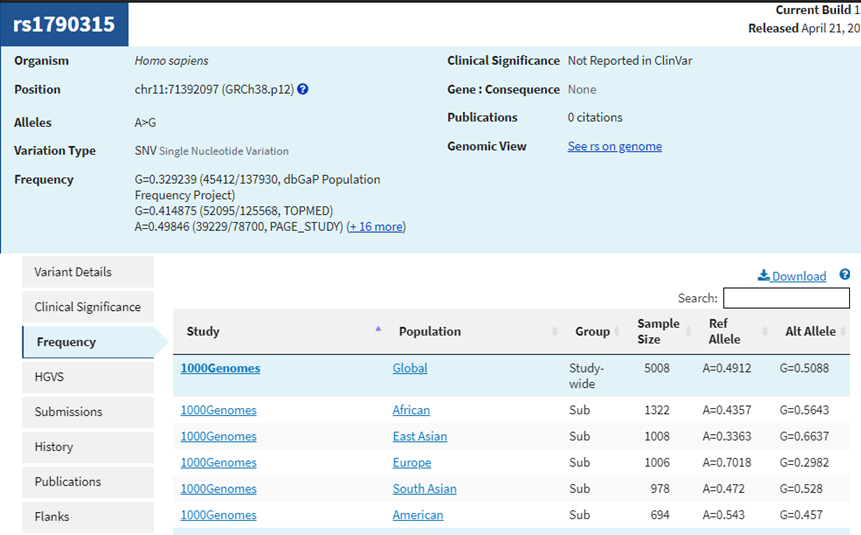




In [6]:
transpose_df.drop(transpose_df.index[[0,1,2]], inplace=True)
transpose_df.index.name = "Indiv_ID"
transpose_df.head()

snp,seq-rs1790315,imm_1_7684595,1kg_1_67617298,rs3777768,1kg_1_159802959,rs7299872,imm_5_131554635,rs35796161,seq-VH-2915,imm_13_43155437,...,imm_17_35321569,imm_1_196009571,imm_1_199241511,rs13188874,rs17386441,rs6838929,imm_22_37997122,imm_14_97465990,rs9541052,seq-rs1339131
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,AA,GG,AG,CG,AG,AA,AA,AC,CC,GG,...,AA,AG,--,AT,AA,GG,GG,AA,GG,GG
8647968039_R01C02,AA,GG,AG,GG,AG,AG,AA,CC,CC,GG,...,AG,AA,AG,AT,AA,GG,GG,AA,AG,GG
6198863118_R02C01,AG,GG,AG,GG,AG,GG,AA,AA,CC,GG,...,AG,AA,--,TT,AA,AG,GG,AA,AG,GG
6198863118_R03C01,AA,GG,AG,GG,AG,AG,AA,AA,CC,GG,...,GG,AA,--,TT,AG,AG,GG,AA,GG,GG
8647968039_R02C02,GG,GG,AG,CG,AG,AG,AA,AA,CC,GG,...,AA,AA,--,TT,AA,GG,GG,AA,GG,AG


**Data exploration**

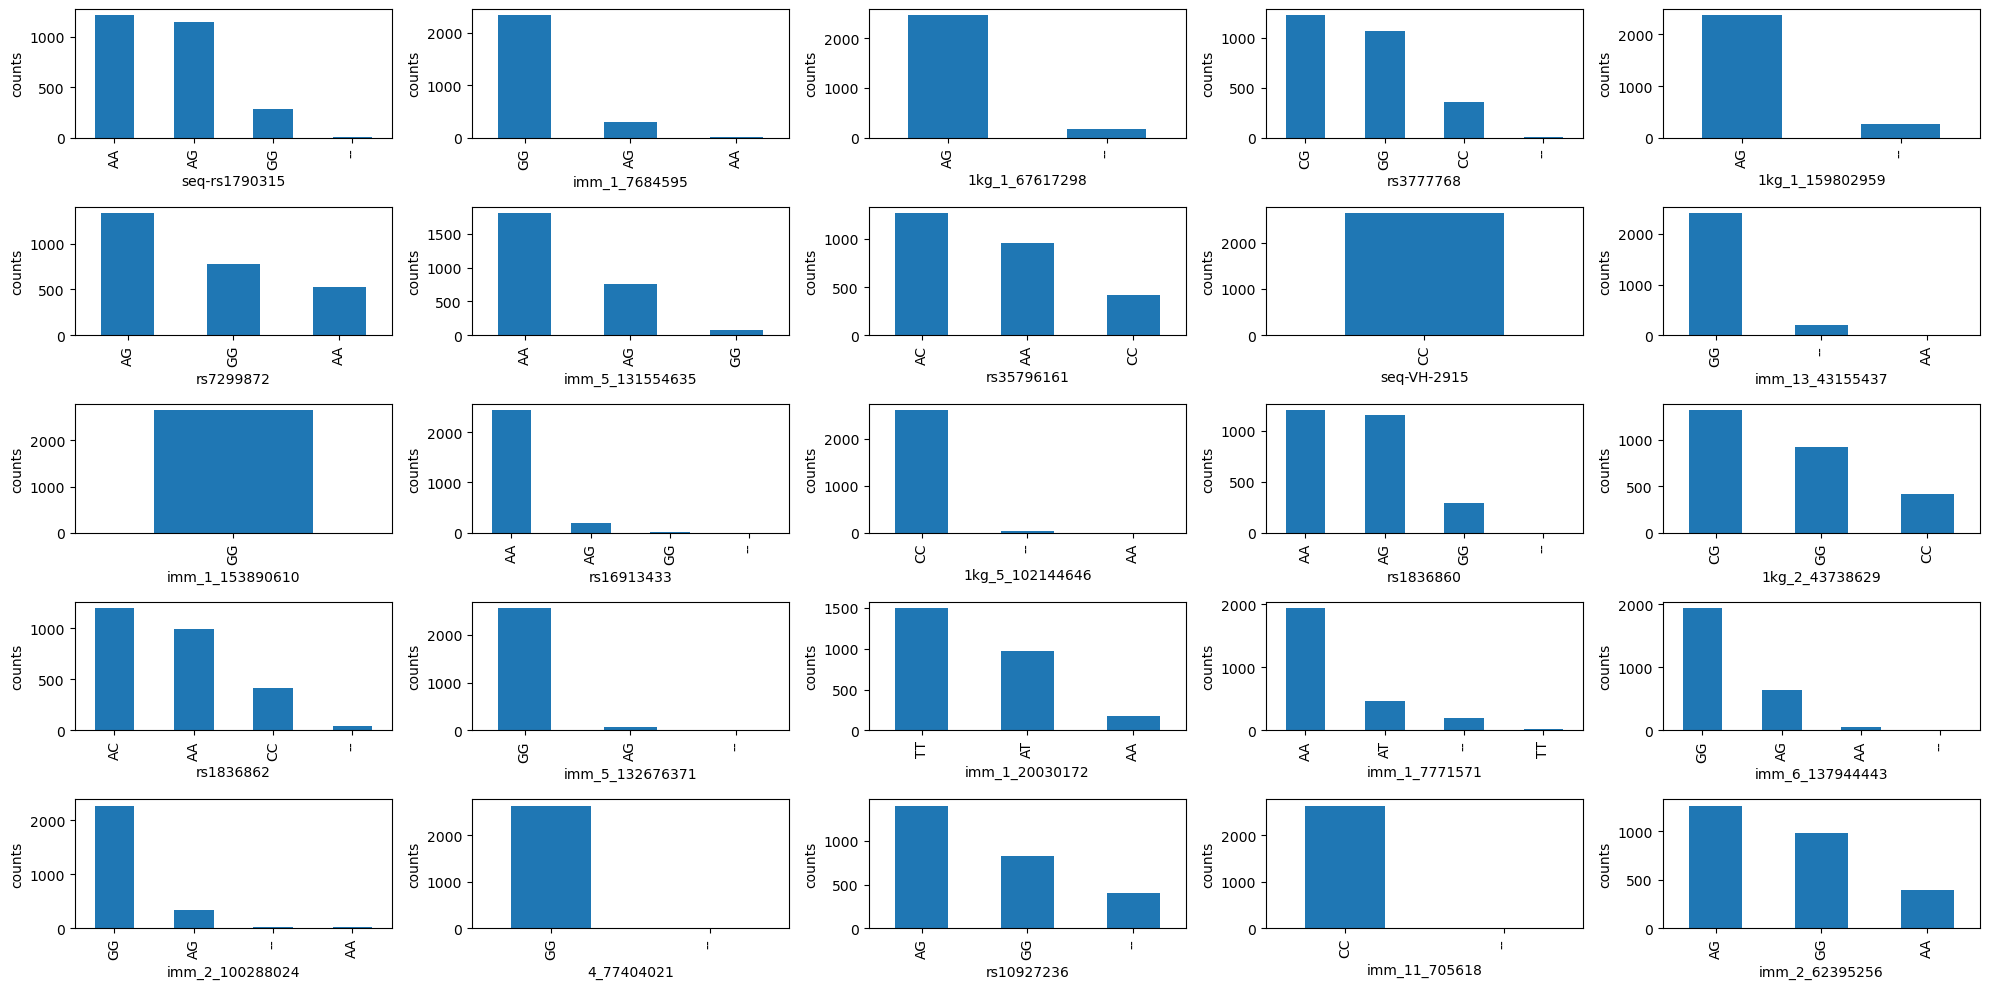

In [7]:

plt.subplots(5,5, figsize = (20,10))
counter = 0
for column in transpose_df.columns[0:25]:
    

    counter+=1
    
    plt.subplot(5,5,counter)

    plt.xlabel(column)
    plt.ylabel("counts")
    transpose_df[column].value_counts().plot(kind='bar')

plt.tight_layout()

plt.show()

In [8]:
unique_items = []
for i in tqdm(transpose_df.columns):
    for item in transpose_df[i].unique():
        if item not in unique_items:
            unique_items.append(item)
print(unique_items)
print(len(unique_items))

100%|████████████████████████████████████████████████████████████████████████| 196523/196523 [02:05<00:00, 1568.03it/s]

['AA', 'AG', 'GG', '--', 'CG', 'CC', 'AC', 'TT', 'AT', 'DD', 'ID', 'II', 'DI']
13


**Data cleaning**

In [9]:
situ_1, situ_2, situ_3, situ_4 = [], [], [], []
for i in tqdm(transpose_df.columns):
    if (transpose_df[i] == "--").sum() / len((transpose_df[i] == "--")) > 0.05:
        #add column name to the list if it does
        situ_1.append(i)
    elif transpose_df[i].nunique() == 1:
        #add column name to the list if it does
        situ_2.append(i)
    elif(transpose_df[i].nunique() == 2) & ("--" in transpose_df[i].unique()):
        #add column name to the list if it does
        situ_3.append(i)
    elif any(k in transpose_df[i].unique() for k in ['AA', 'GG', 'AG', 'CG', 'AC', 'CC', 'TT', 'AT']) == False:
        #add column name to the list if it does
        situ_4.append(i)
        
print(f'# of situ_1 columns: {len(situ_1)}')
print(f'# of situ_2 columns: {len(situ_2)}')
print(f'# of situ_3 columns: {len(situ_3)}')
print(f'# of situ_4 columns: {len(situ_4)}')

100%|█████████████████████████████████████████████████████████████████████████| 196523/196523 [08:11<00:00, 399.45it/s]

# of situ_1 columns: 14061
# of situ_2 columns: 7614
# of situ_3 columns: 19865
# of situ_4 columns: 460


In [10]:
drop_cols_list = np.unique(np.array(situ_1 + situ_2 + situ_3 + situ_4))
print(len(drop_cols_list))

42000


In [11]:
transpose_df.drop(drop_cols_list, inplace = True, axis = 'columns')
print(transpose_df.shape)

(2645, 154523)


In [12]:
all_cols, maj_allele, maj_allele_counts, min_allele, min_allele_counts, maf_cols = [], [], [], [], [], []


for i in tqdm(transpose_df.columns):
    
    #First create an empty string
    my_string = ""
    

    for snp_pairs in transpose_df[i]:

        my_string = my_string + str(snp_pairs)
    

    counts=Counter(my_string) 
    

    sorted_x = sorted(counts.items(), key=lambda kv: kv[1], reverse = True)
    sorted_dict = collections.OrderedDict(sorted_x)
    

    maj_allele.append(list(sorted_dict.keys())[0])
    

    maj_allele_counts.append(list(sorted_dict.values())[0])
    

    min_allele.append(list(sorted_dict.keys())[1])
    

    min_allele_counts.append(list(sorted_dict.values())[1])
    

    all_cols.append(i)      


    MAF = list(sorted_dict.values())[1] / (list(sorted_dict.values())[1] + list(sorted_dict.values())[0])
    if MAF < 0.02:
        #Collect the low frequency ones
        maf_cols.append(i)
        
print(len(maf_cols))      
print(len(all_cols))
print(len(maj_allele))
print(len(min_allele))
print(len(maj_allele_counts))
print(len(min_allele_counts))

100%|█████████████████████████████████████████████████████████████████████████| 154523/154523 [04:45<00:00, 540.39it/s]

25910
154523
154523
154523
154523
154523


In [13]:
transpose_df.drop(maf_cols, inplace = True, axis = 'columns')
print(transpose_df.shape)

(2645, 128613)


In [14]:
allele_df = pd.DataFrame([maj_allele, maj_allele_counts, min_allele, min_allele_counts], columns = all_cols)


allele_df.drop(maf_cols, inplace = True, axis = 'columns')


allele_df.head()

,seq-rs1790315,imm_1_7684595,rs3777768,rs7299872,imm_5_131554635,rs35796161,rs16913433,rs1836860,1kg_2_43738629,rs1836862,...,rs6588810,1kg_14_34546424,imm_9_138301427,imm_17_35321569,imm_1_196009571,rs13188874,rs17386441,imm_22_37997122,rs9541052,seq-rs1339131
0,A,G,G,G,A,A,A,A,G,A,...,G,A,T,A,A,T,A,G,G,G
1,3573,4964,3350,2896,4372,3190,5065,3552,3145,3177,...,4555,4321,4548,2694,4748,4418,4624,5131,4444,2992
2,G,A,C,A,G,C,G,G,C,C,...,A,G,A,G,G,A,G,A,A,A
3,1709,326,1932,2394,918,2100,219,1736,2145,2027,...,657,817,722,2588,542,870,666,141,840,2298


In [15]:

missing_minor_allele_list = []


for i in allele_df.columns:
    
    
    if "-" in allele_df[i].unique():
        
        #Add that column to the list
        missing_minor_allele_list.append(i)

       
print(len(missing_minor_allele_list))

1931


In [16]:
transpose_df.drop(missing_minor_allele_list, inplace = True, axis = 'columns')
print(transpose_df.shape)

allele_df.drop(missing_minor_allele_list, inplace = True, axis = 'columns')
print(allele_df.shape)

(2645, 126682)
(4, 126682)


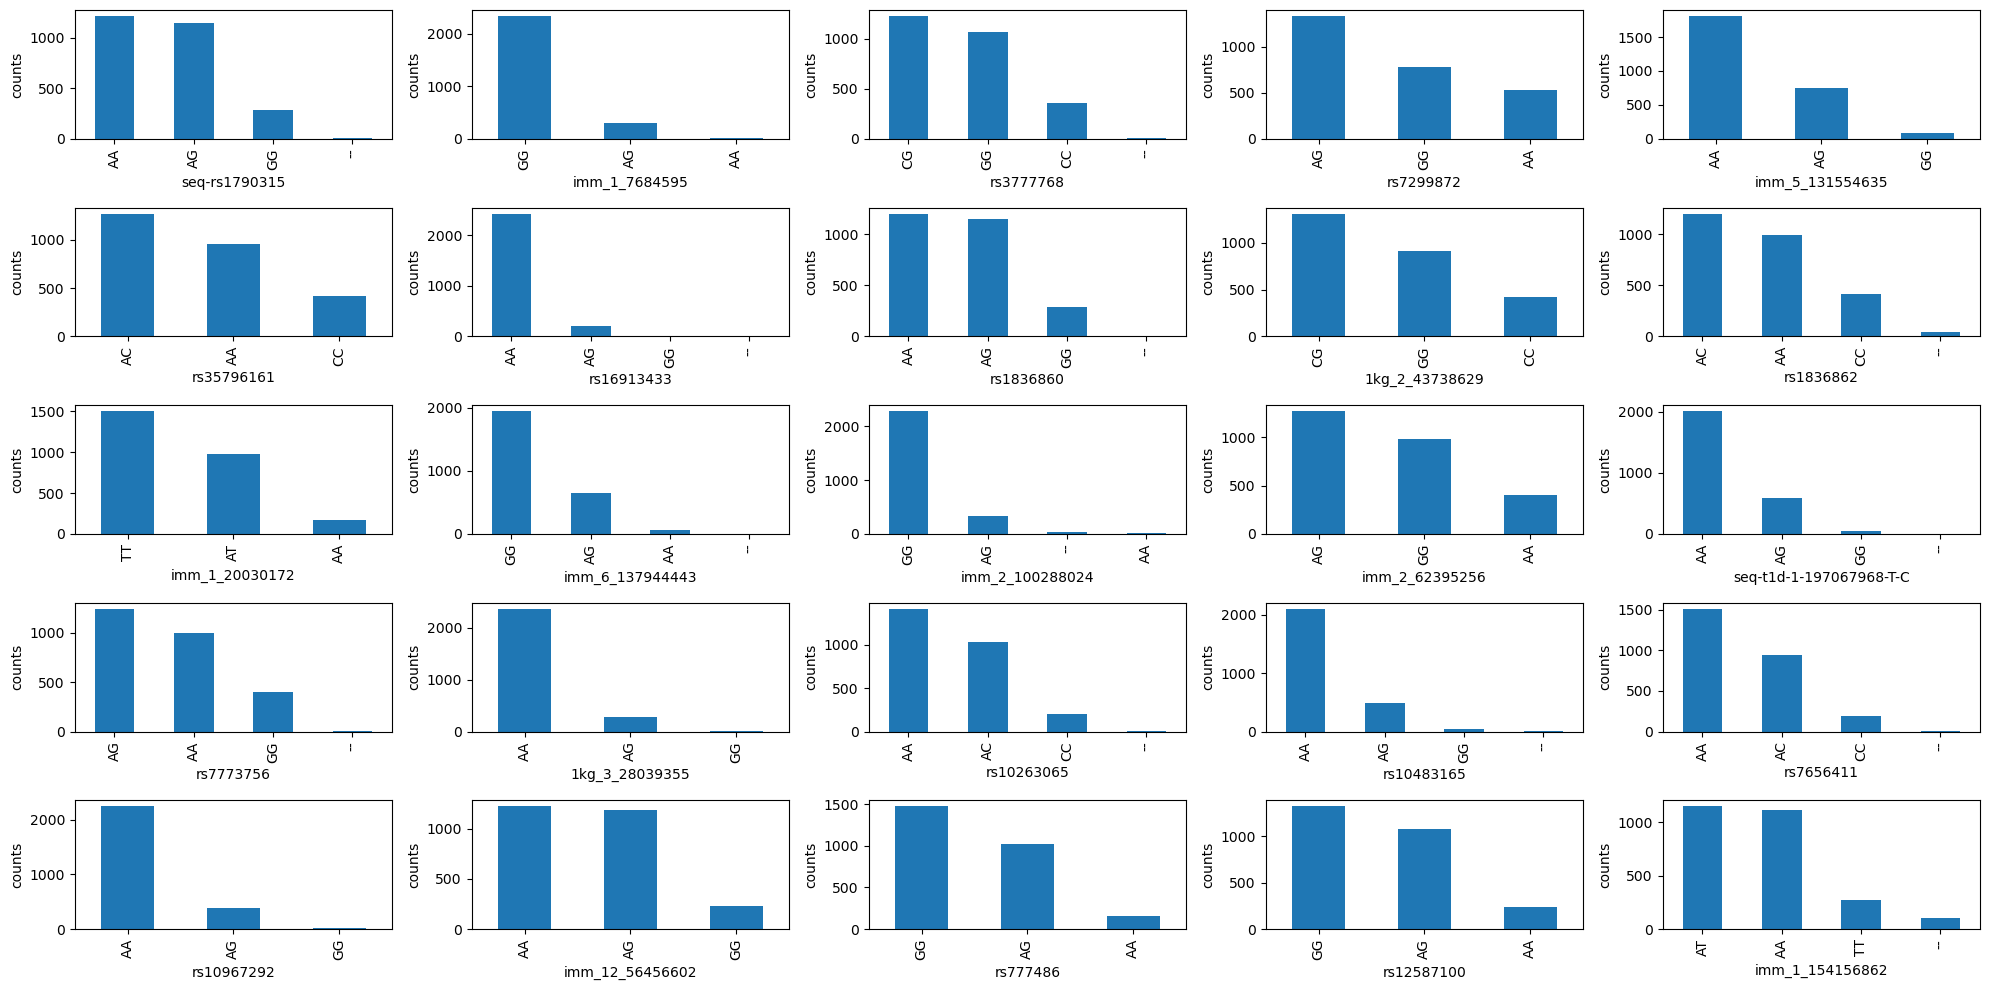

In [17]:
plt.subplots(5,5, figsize = (20,10))


counter = 0


for column in transpose_df.columns[0:25]:
    

    counter+=1
    

    plt.subplot(5,5,counter)
    

    plt.xlabel(column)
    plt.ylabel("counts")
    

    transpose_df[column].value_counts().plot(kind='bar')


plt.tight_layout()

plt.show()

In [18]:

patients= pd.read_csv("data\Combined_2645_Samples_Pedigree.csv")


patients = patients.set_index("Indiv_ID")


patients.head()

,Family_ID,Dad_ID,Mom_ID,Gender,Affectation,Disease
Indiv_ID,,,,,,
8370858003_R03C02,Fm8370858003_R03C02,0,0,1,2,CD
8370858003_R06C01,Fm8370858003_R06C01,0,0,1,2,CD
6298194052_R01C01,Fm6298194052_R01C01,0,0,2,2,CD
7384449023_R01C02,Fm7384449023_R01C02,0,0,1,2,CD
8370858003_R02C02,Fm8370858003_R02C02,0,0,2,2,CD


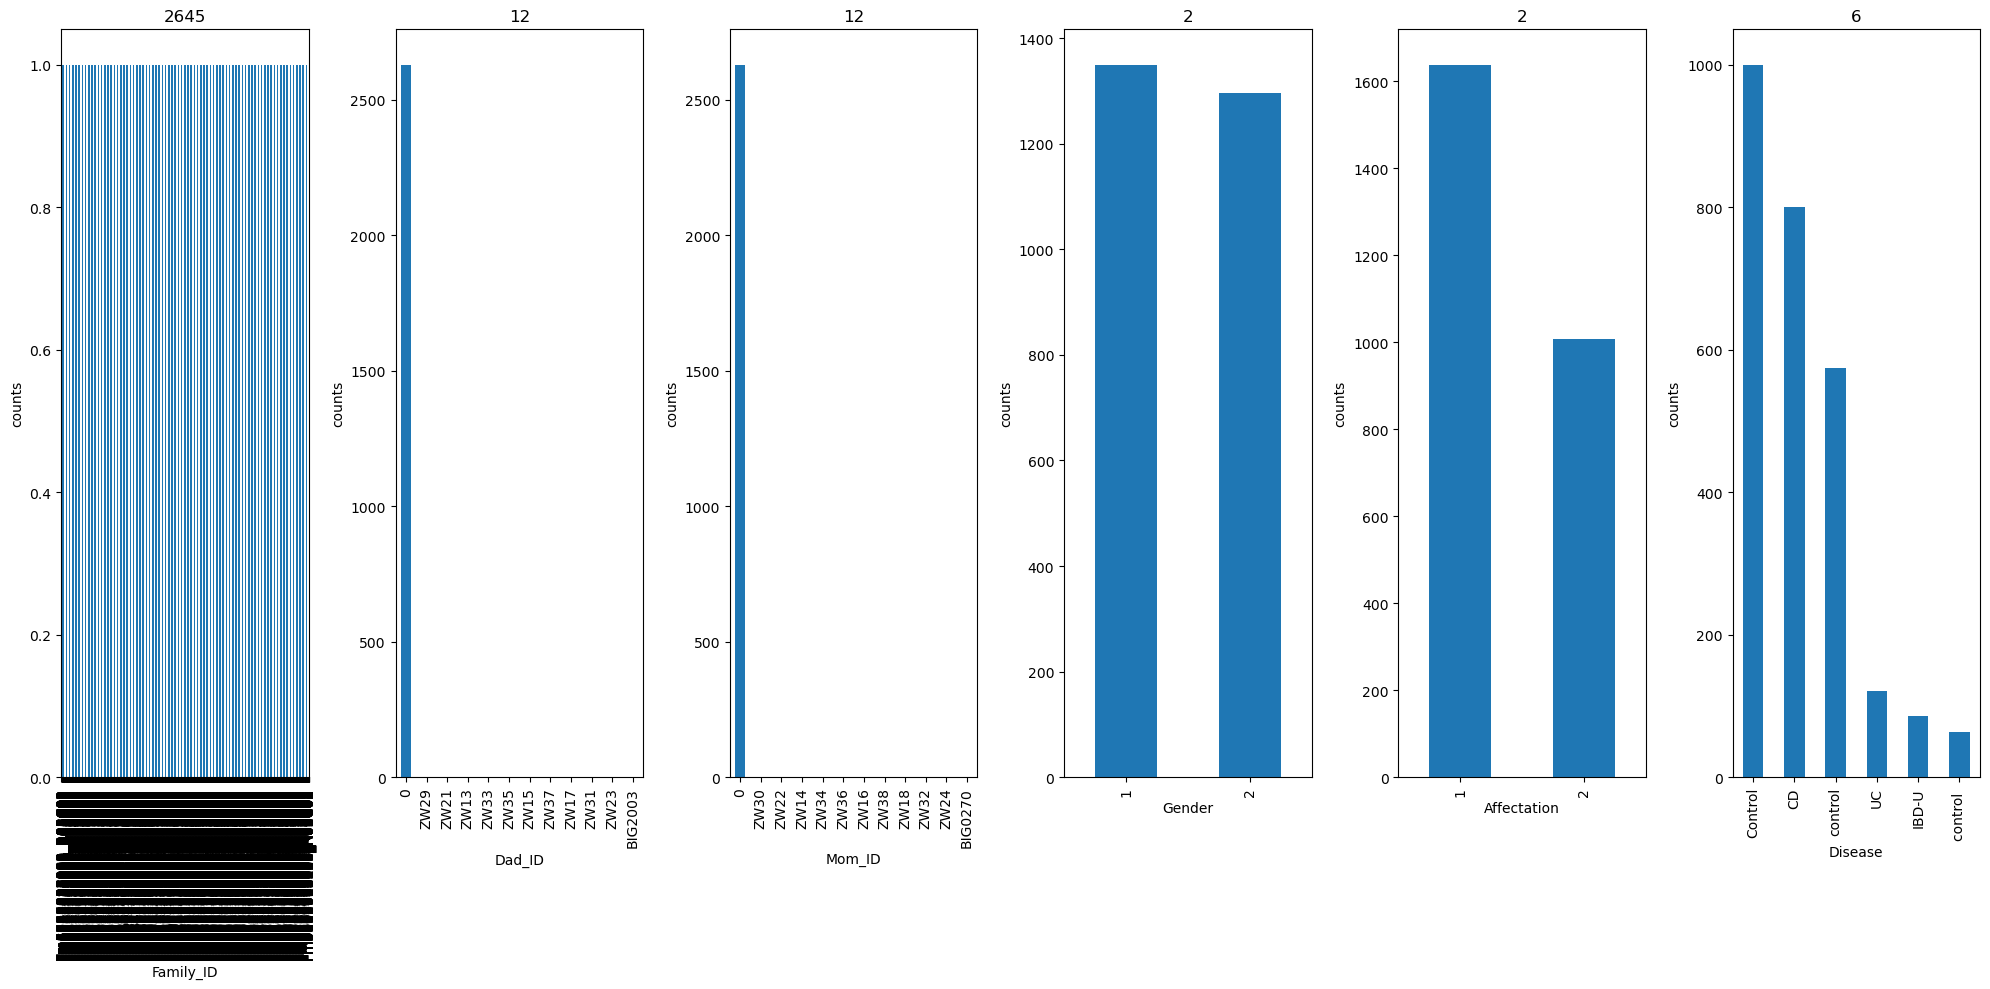

In [19]:

plt.subplots(1,6, figsize = (20,10))


counter = 0


for column in patients.columns:
    

    counter+=1
    

    plt.subplot(1,6,counter)
    

    plt.xlabel(column)
    plt.ylabel("counts")
    plt.title(patients[column].nunique())
    

    patients[column].value_counts().plot(kind='bar')


plt.tight_layout()


plt.show()

In [20]:

patients.drop(["Family_ID","Dad_ID", "Mom_ID", "Disease"], axis='columns', inplace = True)


patients.head()

,Gender,Affectation
Indiv_ID,,
8370858003_R03C02,1,2
8370858003_R06C01,1,2
6298194052_R01C01,2,2
7384449023_R01C02,1,2
8370858003_R02C02,2,2


In [21]:
patients["Gender"] = np.where(patients["Gender"] == 2, 0, patients["Gender"])
patients["Affectation"] = np.where(patients["Affectation"] == 2, 1, 0)
patients.head()

,Gender,Affectation
Indiv_ID,,
8370858003_R03C02,1,1
8370858003_R06C01,1,1
6298194052_R01C01,0,1
7384449023_R01C02,1,1
8370858003_R02C02,0,1


In [22]:
full_df = pd.concat([transpose_df, patients], axis=1, ignore_index=False)
full_df.head()

,seq-rs1790315,imm_1_7684595,rs3777768,rs7299872,imm_5_131554635,rs35796161,rs16913433,rs1836860,1kg_2_43738629,rs1836862,...,imm_9_138301427,imm_17_35321569,imm_1_196009571,rs13188874,rs17386441,imm_22_37997122,rs9541052,seq-rs1339131,Gender,Affectation
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,AA,GG,CG,AA,AA,AC,AA,AG,CG,AA,...,TT,AA,AG,AT,AA,GG,GG,GG,0,0
8647968039_R01C02,AA,GG,GG,AG,AA,CC,AA,AA,CG,AA,...,TT,AG,AA,AT,AA,GG,AG,GG,0,0
6198863118_R02C01,AG,GG,GG,GG,AA,AA,AA,GG,CG,AC,...,AT,AG,AA,TT,AA,GG,AG,GG,0,0
6198863118_R03C01,AA,GG,GG,AG,AA,AA,AA,GG,CC,AA,...,AT,GG,AA,TT,AG,GG,GG,GG,1,0
8647968039_R02C02,GG,GG,CG,AG,AA,AA,AA,AA,GG,AC,...,AT,AA,AA,TT,AA,GG,GG,AG,0,0


In [23]:
healthy_df = full_df[full_df["Affectation"] == 0]
diseased_df = full_df[full_df["Affectation"] == 1]
print(healthy_df.shape)
print(diseased_df.shape)

(1637, 126684)
(1008, 126684)


In [24]:
def create_healthy_counts_df(column):
    key_list, count_list = [], []
    
    #Create an empty string
    my_string = ""
    for snp_pairs in healthy_df[column]:
        my_string = my_string + str(snp_pairs)
    counts=Counter(my_string) 
    
    for key in counts.keys():
            if key in ["A", "C", "G", "T"]:
                key_list.append(key), count_list.append(counts[key])
            else:
                continue
    blah = pd.DataFrame([key_list, count_list]).T.set_index(0)
    blah.columns = ["healthy"]
    return blah

In [25]:
def create_diseased_counts_df(column):
    key_list, count_list = [], []
    my_string = ""
    for snp_pairs in diseased_df[column]:
        my_string = my_string + str(snp_pairs)
    counts=Counter(my_string) 
    
    for key in counts.keys():
            #If the key is DNA letter 
            if key in ["A", "C", "G", "T"]:
                #then keep a count
                key_list.append(key), count_list.append(counts[key])
            #otherwise skip this
            else:
                continue
                
    blah = pd.DataFrame([key_list, count_list]).T.set_index(0)
    blah.columns = ["diseased"]
    return blah

Then run chi-squared tests for each snp location which outputs a p-value for each association.

In [26]:
from scipy.stats import chi2_contingency

p_values_list, columns_list = [], []
counter = 0
for my_columns in tqdm(full_df.columns[:-2]):
    my_df = create_healthy_counts_df(my_columns)
    
    my_df2 = create_diseased_counts_df(my_columns)
    concat_df = pd.concat([my_df, my_df2], axis = 1)
    concat_df.fillna(1)
    
    #add name to columns_list
    columns_list.append(my_columns)
    
    #Calculate chi-squared test p-values
    stat, p, dof, expected = chi2_contingency(concat_df)
    p_values_list.append(p)      
pval_df = pd.DataFrame(p_values_list, columns = ["p_values"])
print(pval_df.shape)

100%|█████████████████████████████████████████████████████████████████████████| 126682/126682 [07:18<00:00, 288.86it/s]

(126682, 1)


In [27]:
 indices_to_keep = pval_df[pval_df["p_values"] < 1e-7].index
print(len(indices_to_keep))

413


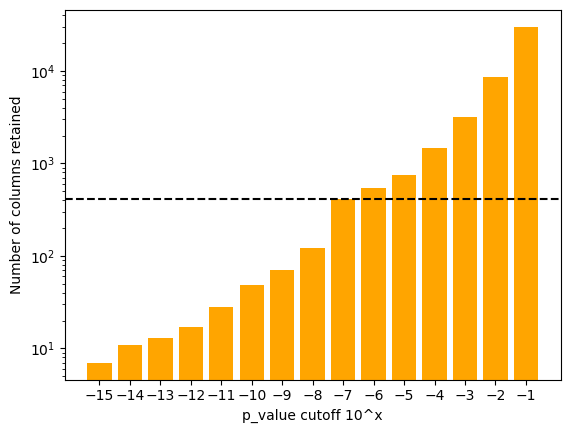

In [28]:

p_val_range = np.arange(-15,0,1)


cols_to_keep = []

for i in p_val_range:
    
    #Keep those indexes where p_value is less than the value specified by 10.0**i
    idx_to_keep = pval_df[pval_df["p_values"] < 10.0**i].index
    
    #append length of idx_to_keep object to cols_to_keep list 
    cols_to_keep.append(len(idx_to_keep))
    

plt.figure()  
plt.bar(p_val_range, cols_to_keep, log=True, color='orange')
plt.xticks(p_val_range)
plt.axhline(413, linestyle = "--", c="black")
plt.xlabel("p_value cutoff 10^x")
plt.ylabel("Number of columns retained")
plt.show()

In [29]:

columns_to_keep = full_df.columns[indices_to_keep]

In [30]:
clean_df = full_df[columns_to_keep]
clean_df.shape

(2645, 413)

In [31]:
clean_df = pd.concat([clean_df, patients], axis=1, ignore_index=False)
clean_df.head()

,rs3769005,imm_1_67459652,imm_7_51057559,rs2959751,imm_3_49619016,imm_16_49296951,imm_3_49522565,rs2534123,rs3100566,rs2254400,...,imm_10_101280291,rs2552595,imm_5_158466251,rs1375132,rs1375131,rs2563397,1kg_1_241045805,rs34367277,Gender,Affectation
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,GG,AG,AG,AA,GG,GG,AA,GG,GG,AA,...,AA,AA,GG,AA,AA,GG,AA,GG,0,0
8647968039_R01C02,GG,AG,GG,AA,AG,AG,AG,GG,GG,AA,...,GG,AA,GG,AA,AA,GG,AA,GG,0,0
6198863118_R02C01,GG,AA,GG,AA,AG,GG,AG,GG,GG,AA,...,AA,AA,GG,AA,AA,GG,AA,GG,0,0
6198863118_R03C01,CG,GG,AG,AG,AG,AG,AG,AG,AG,AG,...,AG,AG,GG,AG,GG,AG,AG,AG,1,0
8647968039_R02C02,GG,AA,GG,AA,GG,AG,AA,GG,GG,AA,...,AG,AA,GG,AA,AA,GG,AA,GG,0,0


In [32]:
 
some_df = pd.concat([pd.Series(columns_list), pval_df], axis= 'columns')


some_df.columns = ["snp", "p_values"]

some_df.head()

,snp,p_values
0,seq-rs1790315,0.214077
1,imm_1_7684595,0.082743
2,rs3777768,0.305179
3,rs7299872,0.076392
4,imm_5_131554635,0.860756


In [33]:

plot_portion = pd.merge(some_df, genotypes.iloc[:,0:3], on="snp", how = 'left')


plot_portion["-10logP"] = -np.log10(plot_portion["p_values"])


plot_portion["chr"] = plot_portion["chr"].astype(str)

plot_portion

,snp,p_values,chr,pos,-10logP
0,seq-rs1790315,0.214077,11,70780791,0.669430
1,imm_1_7684595,0.082743,1,7684595,1.082267
2,rs3777768,0.305179,6,12255600,0.515446
3,rs7299872,0.076392,12,55233823,1.116954
4,imm_5_131554635,0.860756,5,131554635,0.065120
...,...,...,...,...,...
126677,rs13188874,0.352314,5,129698191,0.453070
126678,rs17386441,0.818444,1,98818587,0.087011
126679,imm_22_37997122,0.803290,22,37997122,0.095128
126680,rs9541052,0.277689,13,67855709,0.556442


In [34]:
plot_portion["chr"].unique()

array(['11', '1', '6', '12', '5', '3', '2', '7', '22', '4', '9', '14',
       'XY', '8', '17', '10', '21', '16', '19', '13', '18', '15', 'X',
       '20', 'Y'], dtype=object)

In [35]:



list1 = ["X", "Y", "XY"]

list2 = list(plot_portion[~plot_portion["chr"].isin(list1)]["chr"].unique())


list2.sort(key=int)


list2 = list2 + list1

print(list2)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'XY']


In [36]:
numbers_list = np.arange(1,26)


my_dict = dict(zip(list2, numbers_list))


print(my_dict)

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, 'X': 23, 'Y': 24, 'XY': 25}


In [37]:
plot_portion = plot_portion.sort_values(by=['chr', "pos"], key=lambda x: x.map(my_dict))[["snp", "chr", "pos", "-10logP"]]
plot_portion

,snp,chr,pos,-10logP
1,imm_1_7684595,1,7684595,1.082267
10,imm_1_20030172,1,20030172,0.650885
14,seq-t1d-1-197067968-T-C,1,197067968,0.180983
24,imm_1_154156862,1,154156862,3.189491
27,imm_1_181823018,1,181823018,0.107248
...,...,...,...,...
126498,rs1700954,XY,2618135,0.558174
126565,rs2563397,XY,91022440,7.280999
126585,rs5950746,XY,424354,0.162397
126603,rs7055552,XY,1412072,0.317737


In [38]:
running_pos = 0
cumulative_pos = []


for chromosome, group_df in plot_portion.groupby("chr"):
    cumulative_pos.append(group_df["pos"] + running_pos)
    running_pos += group_df["pos"].max()
     
plot_portion["cum_pos"] = pd.concat(cumulative_pos)
plot_portion

,snp,chr,pos,-10logP,cum_pos
1,imm_1_7684595,1,7684595,1.082267,7684595
10,imm_1_20030172,1,20030172,0.650885,20030172
14,seq-t1d-1-197067968-T-C,1,197067968,0.180983,197067968
24,imm_1_154156862,1,154156862,3.189491,154156862
27,imm_1_181823018,1,181823018,0.107248,181823018
...,...,...,...,...,...
126498,rs1700954,XY,2618135,0.558174,3038056103
126565,rs2563397,XY,91022440,7.280999,3126460408
126585,rs5950746,XY,424354,0.162397,3035862322
126603,rs7055552,XY,1412072,0.317737,3036850040


In [39]:
plot_portion["colorgroup"] = np.where(plot_portion["-10logP"] > 7, "A", "B")
plot_portion

,snp,chr,pos,-10logP,cum_pos,colorgroup
1,imm_1_7684595,1,7684595,1.082267,7684595,B
10,imm_1_20030172,1,20030172,0.650885,20030172,B
14,seq-t1d-1-197067968-T-C,1,197067968,0.180983,197067968,B
24,imm_1_154156862,1,154156862,3.189491,154156862,B
27,imm_1_181823018,1,181823018,0.107248,181823018,B
...,...,...,...,...,...,...
126498,rs1700954,XY,2618135,0.558174,3038056103,B
126565,rs2563397,XY,91022440,7.280999,3126460408,A
126585,rs5950746,XY,424354,0.162397,3035862322,B
126603,rs7055552,XY,1412072,0.317737,3036850040,B


<Figure size 640x480 with 0 Axes>

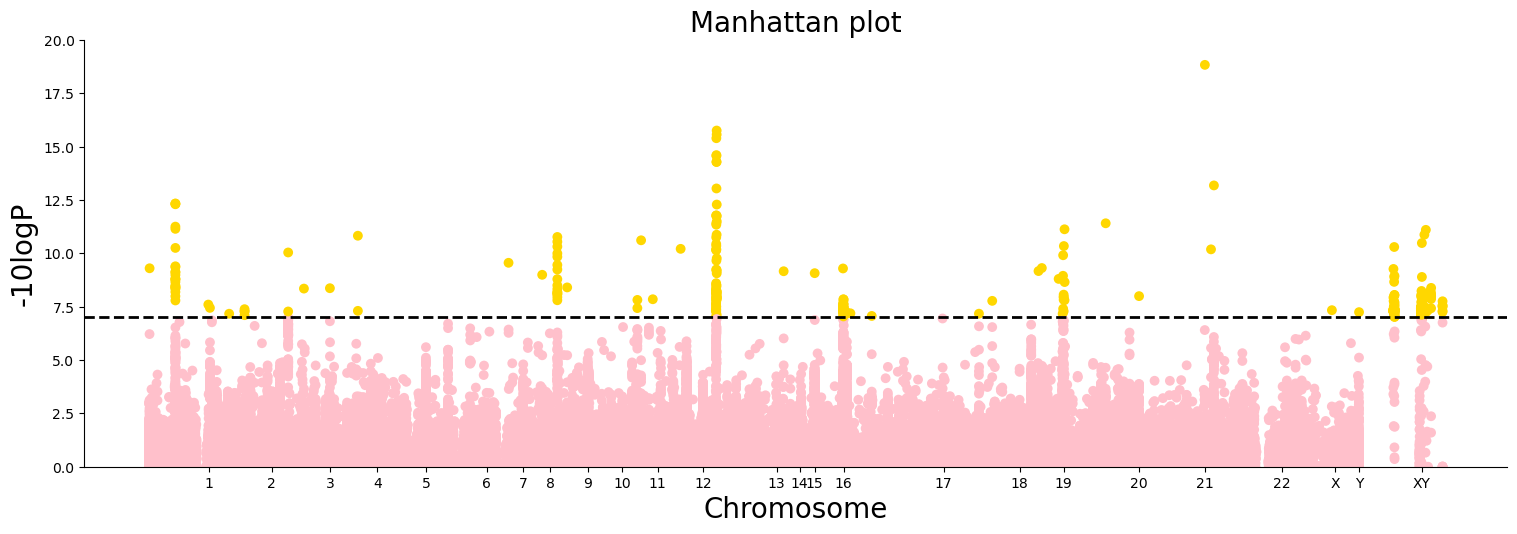

In [40]:

plt.figure()


g = sns.relplot(data = plot_portion, #Data is the dataframe
            x = "cum_pos", #X-axis
            y = "-10logP", #Y-axis
            hue = "colorgroup", #Set colors of points using the colorgroups we defined earlier
            palette = ["pink","gold"], #color the groups A and B with gold and pink respectively
            aspect = 3, #This setting makes the plot 3x as wide as it is tall
            s=50, #sets dot size to 50
            linewidth = 0, #removes outlines of the dots
            legend = None) #no legend


g.ax.set_xlabel("Chromosome", fontsize = 20) 
g.ax.set_ylabel("-10logP", fontsize = 20) 


 
x_label_locations = plot_portion.groupby(["chr"]).median()["cum_pos"]
g.ax.set_xticks(x_label_locations)


g.ax.set_xticklabels(plot_portion["chr"].unique())


plt.axhline(7, linestyle = '--', c='black', linewidth = 2)


plt.ylim(0,20)

plt.title("Manhattan plot", fontsize = 20)#show the plot
plt.show()

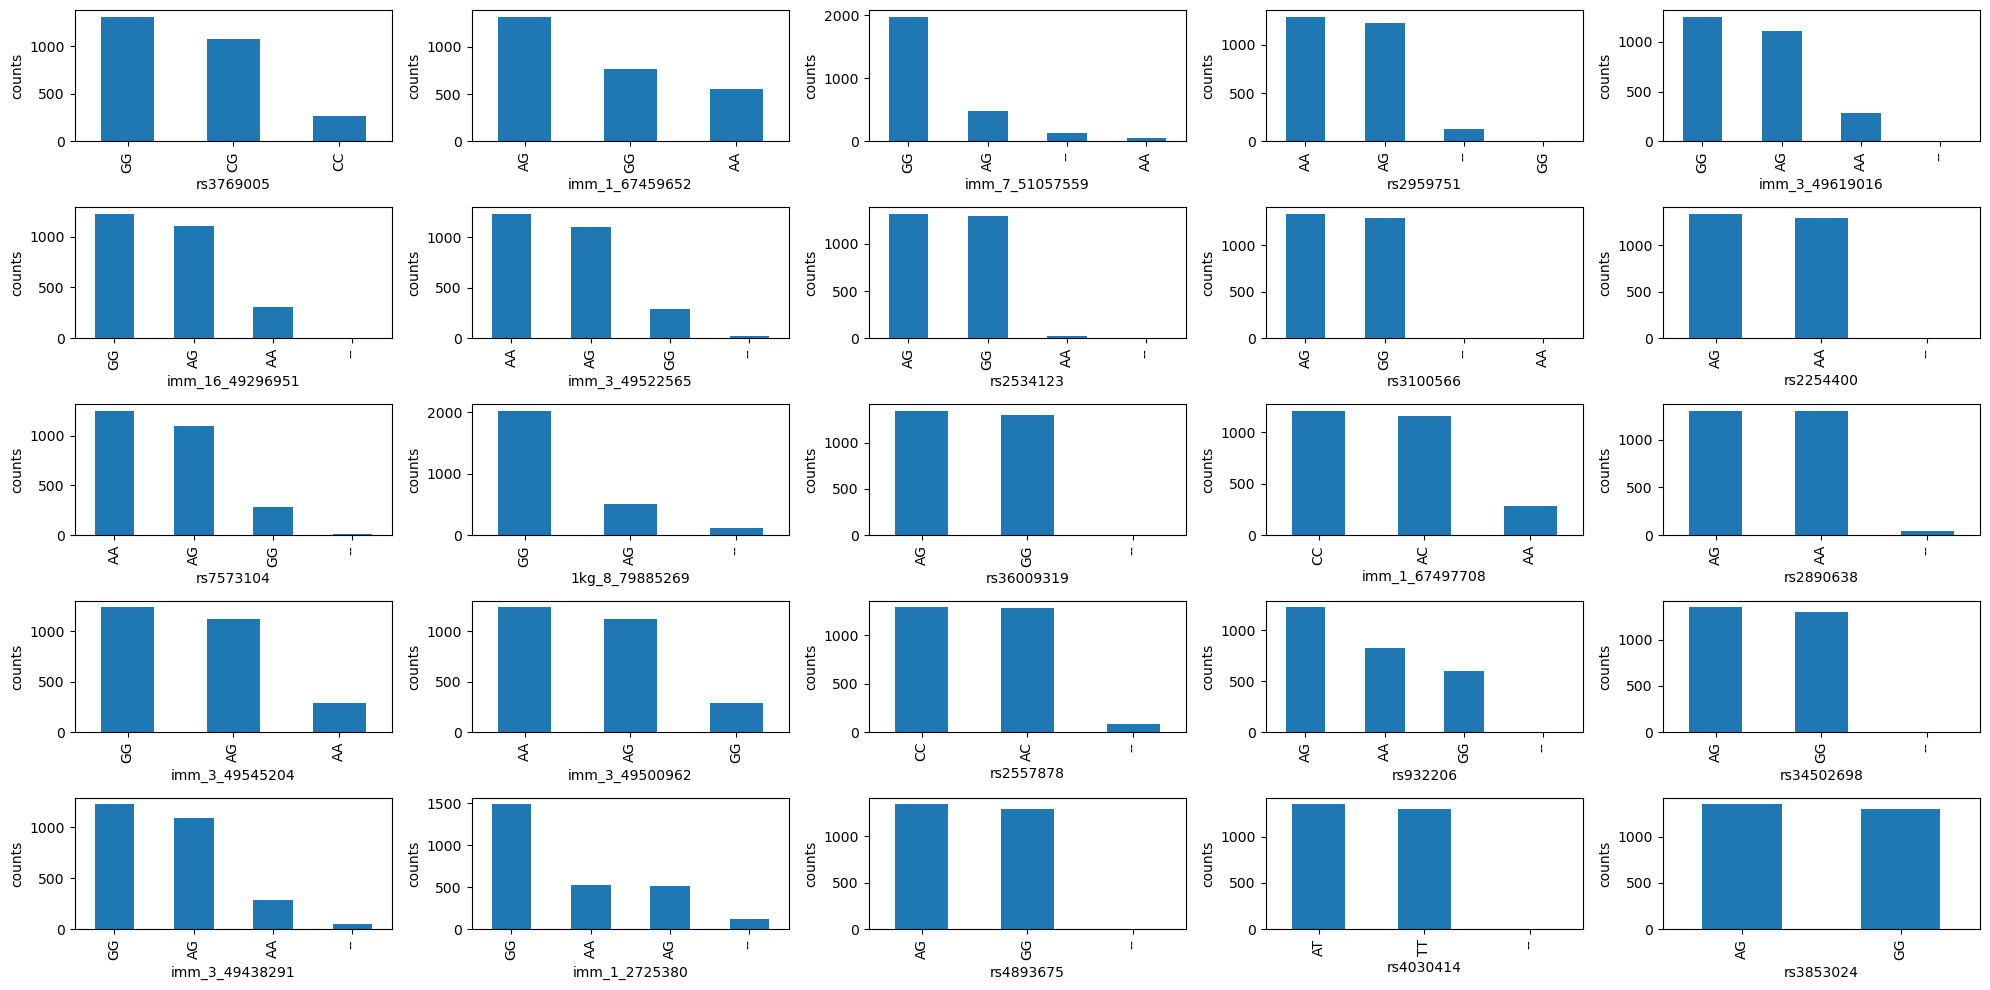

In [41]:

plt.subplots(5,5, figsize = (20,10))


counter = 0


for column in clean_df.columns[0:25]:
    
    counter+=1
    

    plt.subplot(5,5,counter)
    

    plt.xlabel(column)
    plt.ylabel("counts")
    

    clean_df[column].value_counts().plot(kind='bar')


plt.tight_layout()


plt.show()

In [42]:
dummies_df = pd.get_dummies(clean_df)
dummies_df.head()

,Gender,Affectation,rs3769005_CC,rs3769005_CG,rs3769005_GG,imm_1_67459652_AA,imm_1_67459652_AG,imm_1_67459652_GG,imm_7_51057559_--,imm_7_51057559_AA,...,rs1375131_AG,rs1375131_GG,rs2563397_AG,rs2563397_GG,1kg_1_241045805_--,1kg_1_241045805_AA,1kg_1_241045805_AG,rs34367277_--,rs34367277_AG,rs34367277_GG
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
8647968039_R01C02,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
6198863118_R02C01,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
6198863118_R03C01,1,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,1,0
8647968039_R02C02,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


In [43]:

affectation_df = dummies_df.pop("Affectation")


dummies_df["Affectation"] = affectation_df

dummies_df.head()

,Gender,rs3769005_CC,rs3769005_CG,rs3769005_GG,imm_1_67459652_AA,imm_1_67459652_AG,imm_1_67459652_GG,imm_7_51057559_--,imm_7_51057559_AA,imm_7_51057559_AG,...,rs1375131_GG,rs2563397_AG,rs2563397_GG,1kg_1_241045805_--,1kg_1_241045805_AA,1kg_1_241045805_AG,rs34367277_--,rs34367277_AG,rs34367277_GG,Affectation
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
8647968039_R01C02,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
6198863118_R02C01,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
6198863118_R03C01,1,0,1,0,0,0,1,0,0,1,...,1,1,0,0,0,1,0,1,0,0
8647968039_R02C02,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [44]:
dummies_cols = pd.Series(dummies_df.columns)


no_dashes_df = pd.DataFrame(dummies_cols)


no_dashes_df[["1","2"]] = no_dashes_df[0].str.rsplit(pat = "_", n=1, expand = True)
no_dashes_df

,0,1,2
0,Gender,Gender,None
1,rs3769005_CC,rs3769005,CC
2,rs3769005_CG,rs3769005,CG
3,rs3769005_GG,rs3769005,GG
4,imm_1_67459652_AA,imm_1_67459652,AA
...,...,...,...
1397,1kg_1_241045805_AG,1kg_1_241045805,AG
1398,rs34367277_--,rs34367277,--
1399,rs34367277_AG,rs34367277,AG
1400,rs34367277_GG,rs34367277,GG


In [45]:
drop_dashes_columns = no_dashes_df[no_dashes_df["2"]== "--"][0]
drop_dashes_columns

7        imm_7_51057559_--
11            rs2959751_--
15       imm_3_49619016_--
19      imm_16_49296951_--
23       imm_3_49522565_--
               ...        
1379          rs2552595_--
1382    imm_5_158466251_--
1389          rs1375131_--
1395    1kg_1_241045805_--
1398         rs34367277_--
Name: 0, Length: 344, dtype: object

In [46]:
dummies_df.drop(drop_dashes_columns, inplace = True, axis = 'columns')
dummies_df.head()

,Gender,rs3769005_CC,rs3769005_CG,rs3769005_GG,imm_1_67459652_AA,imm_1_67459652_AG,imm_1_67459652_GG,imm_7_51057559_AA,imm_7_51057559_AG,imm_7_51057559_GG,...,rs1375131_AA,rs1375131_AG,rs1375131_GG,rs2563397_AG,rs2563397_GG,1kg_1_241045805_AA,1kg_1_241045805_AG,rs34367277_AG,rs34367277_GG,Affectation
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,0,0,0,1,0,1,0,0,1,0,...,1,0,0,0,1,1,0,0,1,0
8647968039_R01C02,0,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
6198863118_R02C01,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
6198863118_R03C01,1,0,1,0,0,0,1,0,1,0,...,0,0,1,1,0,0,1,1,0,0
8647968039_R02C02,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0


In [47]:
dummies_df.to_csv("GWAS_analysis_OHE.csv", index=True)